In [9]:
from ms2pip.core import annotate_spectra
from denovo_utils.parsers.converters import SpectralisParser
import os
import pandas as pd
import numpy as np
import seaborn as sns
from pyteomics import mgf
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus
from psm_utils import PSM, PSMList
import warnings

warnings.filterwarnings("ignore")

Read in the filtered psms

In [106]:
from ms2pip.result import ProcessingResult
from pyteomics import mass
from pyteomics.mass.mass import Composition
import numpy as np
import warnings
import re

warnings.filterwarnings("ignore")

LOG_NULL = np.float32(np.round(np.log2(.001), 6))

UNIMOD_MOD_COMP = {
    '[UNIMOD:1]': Composition({'H': 2, 'C': 2, 'O': 1}),
    '[UNIMOD:4]': Composition({'H': 3, 'C': 2, 'N': 1, 'O': 1}),
    '[UNIMOD:5]': Composition({'H': 1, 'C': 1, 'N': 1, 'O': 1}),
    '[UNIMOD:7]': Composition({'H': -1, 'N': -1, 'O': 1}),
    '[UNIMOD:21]': Composition({'H': 1, 'O': 3, 'P': 1}),
    '[UNIMOD:23]': Composition({'H': -2, 'O': -1}),
    '[UNIMOD:35]': Composition({'O': 1}),
    '[UNIMOD:385]': Composition({'H': -3, 'N': -1}),
    '[+25.980265]': Composition({'H': 4, 'C': 1, 'N': 2, 'O': 1})
}
UNIMOD_LIST = [
    "[UNIMOD:1]",
    "[UNIMOD:4]",
    "[UNIMOD:5]",
    "[UNIMOD:7]",
    "[UNIMOD:21]",
    "[UNIMOD:23]",
    "[UNIMOD:35]",
    "[UNIMOD:385]",
]

class Evidence:
    def __init__(self, processing_result):
        """
        Initialize peak evidence object for a peptide sequence.

        Can be used to easily compare peptide sequences while allowing isobaric segments.

        Parameter
        ---------
        spectrum: dict or ProcessingResult
            A dictionary with keys 'observed_intensity', 'theoretical_mz' and 'peptide
        """
        self.peptide = processing_result.psm.peptidoform.proforma
        self.processing_result = processing_result
        self.evidence = self.get_evidence(processing_result=processing_result)
        #self.peptide_masked = self.mask_peptide()


    def get_evidence(self, processing_result: ProcessingResult, ion_types=["b", "b2", "y", "y2"]):
        """
        The matching is done with annotate_spectra from ms2pip package. To have evidence of an amino acid, I require a fragment ion series.

        (Could include an implementation where the matching is performed with other evidence peaks as well...)
        """
        psm = processing_result.psm
        mzs = processing_result.theoretical_mz
        intensities = processing_result.observed_intensity

        # Ensure the floats are of the same type
        intensities = {
            k: np.array([np.round(i, 6) for i in v], dtype=np.float32) for k, v in intensities.items()
        }
        observed_bool = {
            k: v!=LOG_NULL for k, v in intensities.items()
        }

        evidence = []
        residue_list = [aa for aa in psm.peptidoform]

        for i, aa in enumerate(psm.peptidoform):
            evidence_types = {}
            evidence_present = False

            if i==len(psm.peptidoform)-1:
                break
            
            for ion_type in ion_types:
                if peak_is_observed(
                    observed_list=observed_bool[ion_type],
                    ion_type=ion_type,
                    ion_number=i
                ):
                    evidence_present = True
                    evidence_types[ion_type] = True
                else:
                    evidence_types[ion_type] = False
                        
            evidence.append(
                {
                    "evidence": evidence_present,
                    "evidence_types": evidence_types,
                    "cleavage_site_residues": [residue_list[i], residue_list[i+1]],
                    "cleavage_site_indices": [i, i+1]
                }
            )

        return evidence
    
    def mask_peptide(self):
        pass
        #self.evidence

    # def __repr__(self):
    #     return self.evidence

    def __eq__(self):
        """
        Allows isobaric alternatives in a portion of the sequence without peak evidence.
        """
        pass


def peak_is_observed(observed_list, ion_type, ion_number):
    # Y peak evidence for amino acid 1 is the yn peak!
    if "y" in ion_type:
        observed_list = observed_list[::-1]
    return observed_list[ion_number]

In [ ]:
psmlist_cols = [
    "peptidoform",
    "spectrum_id",
    "run",
    "score",
    "qvalue",
    "pep",
    "precursor_mz",
    "retention_time"
]
filename="F01_Fraction1"
root_data="/home/samva/Doctorate/data_directory/denovo_project"
mgf_path=os.path.join(root_data, "mgf_filtered", filename + ".mgf")
results_dir=os.path.join(root_data, "denovo_results")

# Read filtered PSMs
fraction1 = pd.read_csv(
    f"/home/samva/Doctorate/data_directory/denovo_project/denovo_results/psmlists/df/{filename}.csv"
)

# Parse to PSMList
psmlist = PSMList(
    psm_list=[PSM(**x) for x in fraction1.loc[:, psmlist_cols].to_dict("records")]
)

# Get processing_result (annotated spectra)
processing_results = annotate_spectra(
    psms=psmlist,
    spectrum_file=mgf_path,
    model="HCDch2"
)



In [92]:
for aa in r.psm.peptidoform:
    print(aa)

('S', None)
('S', None)
('C', [UnimodModification('4', None, None)])
('N', None)
('D', None)
('C', [UnimodModification('4', None, None)])
('R', None)


In [159]:
evidences = []
for r in processing_results:
    evidences.append(Evidence(r))

In [161]:
fraction1["evidence"] = evidences

In [165]:
selection = fraction1.sort_values("spectralis_score").tail(7)[[
    "peptidoform",
    "spectrum_id",
    "score",
    "precursor_mz",
    "metadata",
    "source",
    "spectralis_score",
    "evidence"
]]
selection

,peptidoform,spectrum_id,score,precursor_mz,metadata,source,spectralis_score,evidence
21257,ILDLEHLLDR/3,controllerType=0 controllerNumber=1 scan=15030,-0.487639,412.902025,{},sage,-0.049631,<__main__.Evidence object at 0x7f3c6bb86d90>
15724,FANSEVEVK/2,controllerType=0 controllerNumber=1 scan=7109,94.000000,511.761536,"{'scans': '7109', 'err(data-denovo)': '0.0005'...",Novor,-0.043880,<__main__.Evidence object at 0x7f3c6da7e390>
11062,FANSEVEVK/2,controllerType=0 controllerNumber=1 scan=7109,0.999843,511.761536,"{'aa_scores': '0.99998,0.99996,0.99989,0.99996...",ContraNovo,-0.043880,<__main__.Evidence object at 0x7f3c6f5da8d0>
12911,FANSEVEVK/2,controllerType=0 controllerNumber=1 scan=7109,0.999915,511.761536,"{'ppm_error': '0.0', 'scans': '7109'}",NovoB,-0.043880,<__main__.Evidence object at 0x7f3c6eab0c10>
3966,FANSEVEVK/2,controllerType=0 controllerNumber=1 scan=7109,-0.035272,511.761536,{'scans': '7109'},InstaNovo,-0.043880,<__main__.Evidence object at 0x7f3c71d3e450>
7161,FANSEVEVK/2,controllerType=0 controllerNumber=1 scan=7109,1.000000,511.761536,"{'positional_scores': '[0.9999995, 0.99999714,...",PepNet,-0.043880,<__main__.Evidence object at 0x7f3c70a2eb50>
494,FANSEVEVK/2,controllerType=0 controllerNumber=1 scan=7109,0.989041,511.761536,"{'aa_scores': '0.98976,0.99000,0.98625,0.98982...",Casanovo4.2.0,-0.043880,<__main__.Evidence object at 0x7f3c766ab710>


In [ ]:
fraction1[fraction1.spectrum_id==""]

In [167]:
selection.iloc[-1,-1].evidence

[{'evidence': True,
  'evidence_types': {'b': True, 'b2': False, 'y': True, 'y2': False},
  'cleavage_site_residues': [('F', None), ('A', None)],
  'cleavage_site_indices': [0, 1]},
 {'evidence': True,
  'evidence_types': {'b': True, 'b2': True, 'y': True, 'y2': False},
  'cleavage_site_residues': [('A', None), ('N', None)],
  'cleavage_site_indices': [1, 2]},
 {'evidence': True,
  'evidence_types': {'b': True, 'b2': False, 'y': True, 'y2': False},
  'cleavage_site_residues': [('N', None), ('S', None)],
  'cleavage_site_indices': [2, 3]},
 {'evidence': True,
  'evidence_types': {'b': True, 'b2': False, 'y': True, 'y2': False},
  'cleavage_site_residues': [('S', None), ('E', None)],
  'cleavage_site_indices': [3, 4]},
 {'evidence': True,
  'evidence_types': {'b': True, 'b2': False, 'y': True, 'y2': False},
  'cleavage_site_residues': [('E', None), ('V', None)],
  'cleavage_site_indices': [4, 5]},
 {'evidence': True,
  'evidence_types': {'b': False, 'b2': False, 'y': True, 'y2': False},


In [111]:
from denovo_utils.analysis.visualization import plot_spectrum

In [115]:
ev.peptide

'GLAKQM[UNIMOD:35]R/2'

In [123]:
spec = plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id=ev.processing_result.psm.spectrum_id,
    peptide="GLAKQDM[Oxidation]R/2",
    fragment_tol_mass=50,
    fragment_tol_mode="ppm",
    plot=False
)

In [143]:
ev.evidence

[{'evidence': False,
  'evidence_types': {'b': False, 'b2': False, 'y': False, 'y2': False},
  'cleavage_site_residues': [('G', None), ('L', None)],
  'cleavage_site_indices': [0, 1]},
 {'evidence': True,
  'evidence_types': {'b': True, 'b2': False, 'y': False, 'y2': True},
  'cleavage_site_residues': [('L', None), ('A', None)],
  'cleavage_site_indices': [1, 2]},
 {'evidence': True,
  'evidence_types': {'b': True, 'b2': False, 'y': False, 'y2': False},
  'cleavage_site_residues': [('A', None), ('K', None)],
  'cleavage_site_indices': [2, 3]},
 {'evidence': True,
  'evidence_types': {'b': True, 'b2': False, 'y': False, 'y2': False},
  'cleavage_site_residues': [('K', None), ('Q', None)],
  'cleavage_site_indices': [3, 4]},
 {'evidence': True,
  'evidence_types': {'b': True, 'b2': False, 'y': False, 'y2': False},
  'cleavage_site_residues': [('Q', None),
   ('M', [UnimodModification('35', None, None)])],
  'cleavage_site_indices': [4, 5]},
 {'evidence': True,
  'evidence_types': {'b': F

<Axes: xlabel='m/z', ylabel='Intensity'>

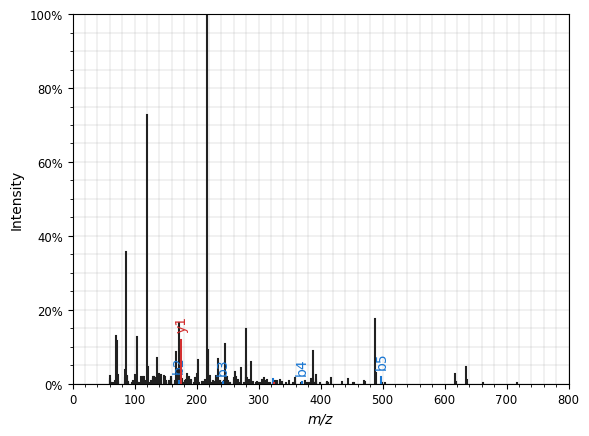

In [156]:
sup.spectrum(spec.annotate_proforma(
    proforma_str="GLAKQM[Oxidation]R/2",
    fragment_tol_mass=.02,
    fragment_tol_mode="Da",
    max_ion_charge=2
))

In [154]:
spec.annotation

array([?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, b2/-0.00029, ?, ?, ?, ?, y1/-0.00015, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, b3/-8e-05, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, b6^2/0.01474, y5^2/0.01218, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, b4/0.0017, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
       ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, b5/-0.00188, ?, ?,
       ?, ?, ?, ?, ?, ?, ?], dtype=object)

In [ ]:
UNIMOD_MOD_COMP

{'[UNIMOD:1]': Composition({'H': 2, 'C': 2, 'O': 1}),
 '[UNIMOD:4]': Composition({'H': 3, 'C': 2, 'N': 1, 'O': 1}),
 '[UNIMOD:5]': Composition({'H': 1, 'C': 1, 'N': 1, 'O': 1}),
 '[UNIMOD:7]': Composition({'H': -1, 'N': -1, 'O': 1}),
 '[UNIMOD:21]': Composition({'H': 1, 'O': 3, 'P': 1}),
 '[UNIMOD:23]': Composition({'H': -2, 'O': -1}),
 '[UNIMOD:35]': Composition({'O': 1}),
 '[UNIMOD:385]': Composition({'H': -3, 'N': -1}),
 '[+25.980265]': Composition({'H': 4, 'C': 1, 'N': 2, 'O': 1})}

<Axes: xlabel='spectralis_score', ylabel='Density'>

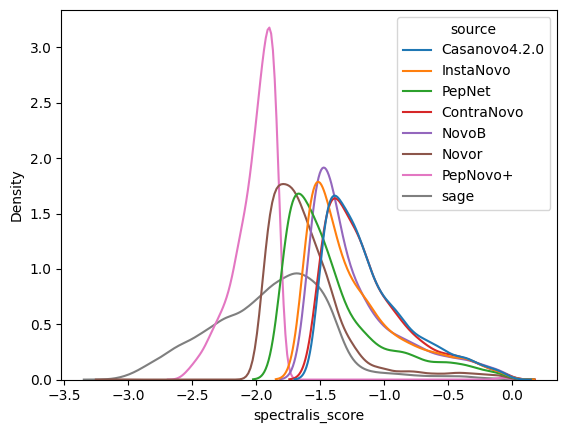

In [3]:
fraction1 = pd.read_csv(
    "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/psmlists/df/F01_Fraction1.csv"
)

sns.kdeplot(
    fraction1,
    x="spectralis_score",
    hue="source",
    common_norm=False
)

In [19]:
from pyteomics import mass

In [20]:
db = mass.Unimod()

mass.std_aa_comp["c"] = db.by_id(4)["composition"]

mass.calculate_mass("SSCcNDCcR", aa_comp=dict(mass.std_aa_comp))/2

448.65344999568504

In [32]:
UNIMOD_LIST = [
    "[UNIMOD:1]",
    "[UNIMOD:4]",
    "[UNIMOD:5]",
    "[UNIMOD:7]",
    "[UNIMOD:21]",
    "[UNIMOD:23]",
    "[UNIMOD:35]",
    "[UNIMOD:385]",
]

In [39]:
import re

pattern = r'\[UNIMOD:(\d+)\]'
db = mass.Unimod()

unimod_comp = {}

for unimod_label in UNIMOD_LIST:
    composition = db.by_id(re.findall(pattern, unimod_label)[0])["composition"]

    unimod_comp[unimod_label] = composition

unimod_comp["[+25.980265]"] = unimod_comp["[UNIMOD:5]"]-unimod_comp["[UNIMOD:385]"]

In [42]:
unimod_comp

{'[UNIMOD:1]': Composition({'H': 2, 'C': 2, 'O': 1}),
 '[UNIMOD:4]': Composition({'H': 3, 'C': 2, 'N': 1, 'O': 1}),
 '[UNIMOD:5]': Composition({'H': 1, 'C': 1, 'N': 1, 'O': 1}),
 '[UNIMOD:7]': Composition({'H': -1, 'N': -1, 'O': 1}),
 '[UNIMOD:21]': Composition({'H': 1, 'O': 3, 'P': 1}),
 '[UNIMOD:23]': Composition({'H': -2, 'O': -1}),
 '[UNIMOD:35]': Composition({'O': 1}),
 '[UNIMOD:385]': Composition({'H': -3, 'N': -1}),
 '[+25.980265]': Composition({'H': 4, 'C': 1, 'N': 2, 'O': 1})}

In [22]:
comp = dict(mass.std_aa_comp)

In [23]:
comp["[UNIMOD:4]"] = db.by_id(4)["composition"]

In [26]:
comp

{'A': Composition({'H': 5, 'C': 3, 'O': 1, 'N': 1}),
 'C': Composition({'H': 5, 'C': 3, 'S': 1, 'O': 1, 'N': 1}),
 'D': Composition({'H': 5, 'C': 4, 'O': 3, 'N': 1}),
 'E': Composition({'H': 7, 'C': 5, 'O': 3, 'N': 1}),
 'F': Composition({'H': 9, 'C': 9, 'O': 1, 'N': 1}),
 'G': Composition({'H': 3, 'C': 2, 'O': 1, 'N': 1}),
 'H': Composition({'H': 7, 'C': 6, 'N': 3, 'O': 1}),
 'I': Composition({'H': 11, 'C': 6, 'O': 1, 'N': 1}),
 'J': Composition({'H': 11, 'C': 6, 'O': 1, 'N': 1}),
 'K': Composition({'H': 12, 'C': 6, 'N': 2, 'O': 1}),
 'L': Composition({'H': 11, 'C': 6, 'O': 1, 'N': 1}),
 'M': Composition({'H': 9, 'C': 5, 'S': 1, 'O': 1, 'N': 1}),
 'N': Composition({'H': 6, 'C': 4, 'O': 2, 'N': 2}),
 'P': Composition({'H': 7, 'C': 5, 'O': 1, 'N': 1}),
 'Q': Composition({'H': 8, 'C': 5, 'O': 2, 'N': 2}),
 'R': Composition({'H': 12, 'C': 6, 'N': 4, 'O': 1}),
 'S': Composition({'H': 5, 'C': 3, 'O': 2, 'N': 1}),
 'T': Composition({'H': 7, 'C': 4, 'O': 2, 'N': 1}),
 'V': Composition({'H': 9

In [25]:
mass.calculate_mass(
    "SSC[UNIMOD:4]NDCcR",
    aa_comp=comp
)

PyteomicsError: Pyteomics error, message: 'Could not create a Composition object from string: "SSC[UNIMOD:4]NDCcR": not a valid sequence or formula'

Parse the spectralis results

In [ ]:
parser_spectralis = SpectralisParser(
    mgf_path=mgf_path,
    results_dir=results_dir
)

# Casanovo, instanovo, pepnet, contranovo ran together
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt1", filename + "_annotated_rescoring.csv"
    )
)

# NovoB, Novor, PepNovo+ ran together
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt2", filename + "_annotated_rescoring.csv"
    )
)

# Sage results ran separately
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt3", filename + "_annotated_rescoring.csv"
    )
)

psmlist = parser_spectralis.psmlist
len(psmlist["run"])
psmlist["run"] = np.array(["F1_Fraction1"]*63612)

Annotate spectra

In [8]:
processing_result_ch2 = annotate_spectra(
    psms=psmlist,
    spectrum_file=mgf_path,
    model="HCDch2"
)

NameError: name 'psmlist' is not defined

In [173]:
pr = [r for r in processing_result_ch2 if (r.psm.spectrum_id=="controllerType=0 controllerNumber=1 scan=7109") and (r.psm.source=="Casanovo4.2.0")]

In [119]:
type(pr[0])

ms2pip.result.ProcessingResult

In [159]:
LOG_NULL = np.float32(np.round(np.log2(.001), 6))

In [157]:
pr[0].observed_intensity = {
    k: np.array([np.round(i, 6) for i in v], dtype=np.float32) for k, v in pr[0].observed_intensity.items()
}

In [162]:
observed_bool = {
    k: v!=LOG_NULL for k, v in pr[0].observed_intensity.items()
}


In [163]:
observed_bool

{'b': array([False, False, False, False, False, False]),
 'y': array([ True,  True,  True, False, False, False]),
 'b2': array([False, False, False, False, False, False]),
 'y2': array([False, False, False, False, False, False])}

In [158]:
pr[0].observed_intensity

{'b': array([-9.965784, -9.965784, -9.965784, -9.965784, -9.965784, -9.965784],
       dtype=float32),
 'y': array([-5.854562, -3.869024, -4.806206, -9.965784, -9.965784, -9.965784],
       dtype=float32),
 'b2': array([-9.965784, -9.965784, -9.965784, -9.965784, -9.965784, -9.965784],
       dtype=float32),
 'y2': array([-9.965784, -9.965784, -9.965784, -9.965784, -9.965784, -9.965784],
       dtype=float32)}

In [144]:
type(np.round(
    pr[0].observed_intensity["b"][0], 6
))

numpy.float32

In [142]:
np.round(
    pr[0].observed_intensity["b"][0], 6
) == np.round(np.log2(.001), 6)

False

In [105]:
for aa in pr[0].psm.peptidoform:
    print(type(aa), aa)

<class 'tuple'> ('S', None)
<class 'tuple'> ('S', None)
<class 'tuple'> ('C', [UnimodModification('4', None, None)])
<class 'tuple'> ('N', None)
<class 'tuple'> ('D', None)
<class 'tuple'> ('C', [UnimodModification('4', None, None)])
<class 'tuple'> ('R', None)


In [166]:
mgf_file = mgf.read(mgf_path)
spectrum = mgf_file.get_by_id("controllerType=0 controllerNumber=1 scan=7109")

In [53]:
print(spectrum.keys(), spectrum["params"].keys())

dict_keys(['params', 'm/z array', 'intensity array', 'charge array']) dict_keys(['title', 'pepmass', 'rtinseconds', 'charge', 'scans'])


In [171]:
spectrum_su1 = sus.MsmsSpectrum(
    identifier=spectrum["params"]["title"],
    precursor_mz=spectrum["params"]["pepmass"][0],
    precursor_charge=spectrum["params"]["charge"][0],
    mz=spectrum["m/z array"],
    intensity=spectrum["intensity array"],
    retention_time=spectrum["params"]["rtinseconds"]
)
spectrum_su2 = sus.MsmsSpectrum(
    identifier=spectrum["params"]["title"],
    precursor_mz=spectrum["params"]["pepmass"][0],
    precursor_charge=spectrum["params"]["charge"][0],
    mz=spectrum["m/z array"],
    intensity=spectrum["intensity array"],
    retention_time=spectrum["params"]["rtinseconds"]
)

spectrum_su1 = spectrum_su1.annotate_proforma(
    proforma_str="FANSEVEVK",
    fragment_tol_mass=50,
    fragment_tol_mode="ppm",
    ion_types="by",
    max_ion_charge=5
)

spectrum_su2 = spectrum_su2.annotate_proforma(
    proforma_str="FANYRSHK",
    fragment_tol_mass=50,
    fragment_tol_mode="ppm",
    ion_types="by",
    max_ion_charge=5
)

<Axes: xlabel='m/z', ylabel='Intensity'>

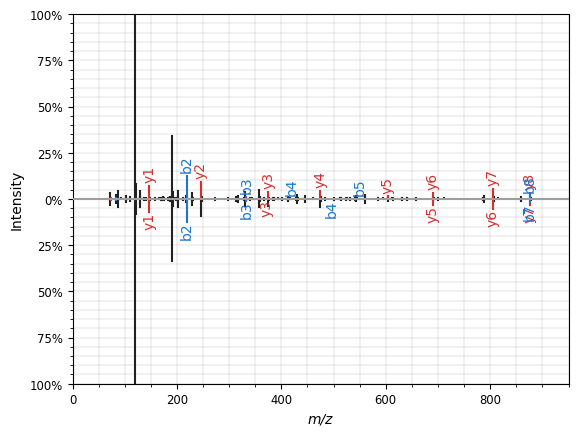

In [172]:
sup.mirror(spectrum_su1, spectrum_su2)

In [112]:
spectrum_su = spectrum_su.annotate_proforma(
    proforma_str="SSC[UNIMOD:4]NDC[UNIMOD:4]R",
    fragment_tol_mass=50,
    fragment_tol_mode="ppm",
    ion_types="by",
    max_ion_charge=5
)

<Axes: xlabel='m/z', ylabel='Intensity'>

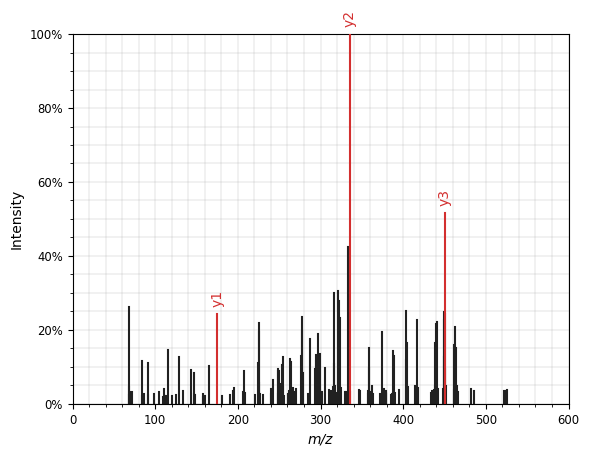

In [113]:
sup.spectrum(
    spectrum_su
)

In [ ]:
usi = "mzspec:PXD014834:TCGA-AA-3518-01A-11_W_VU_20120915_A0218_3F_R_FR01:scan:8370"
peptide = "WNQLQAFWGTGK"
spectrum = sus.MsmsSpectrum.from_usi(usi)
spectrum.annotate_proforma(
    peptide,
    fragment_tol_mass=0.05,
    fragment_tol_mode="Da",
    ion_types="aby",
    max_ion_charge=2,
    neutral_losses={"NH3": -17.026549, "H2O": -18.010565},
)

fig, ax = plt.subplots(figsize=(12, 6))
sup.spectrum(spectrum, annot_fmt=annotate_ion_type, grid=False, ax=ax)
ax.set_title(peptide, fontdict={"fontsize": "xx-large"})
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig("annot_fmt.png", dpi=300, bbox_inches="tight", transparent=True)
plt.close()